# **Lab experience #09 (SOLUTION): Anomaly Detection using proximity-based approaches vs PCA**

This nineth lab session aims **to compare anomaly detection based on proximity-based approaches vs reconstruction-based methods (i.e., PCA)**. This lab session refers to all Prof. Stella's lectures on "Introduction to anomaly detection", "Nearest neighbor based anomaly detection", "Clustering Based, Statistical Approaches and Reconstruction Based".

In this lab session, you will **re-use code already developed in the previous labs** and better explore [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

The main task is to idenfity outliers in _a completely new dataset_ using kNN, LOF, and PCA. Verify agreement or the degree of mismatch among the three different methods. Then, remove the outliers (choosing the best performing method, at your choice), and then discuss on the quality of the remaining dataset.

In [1]:
# Useful packages that you might want to use
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist as pdist
from scipy.spatial.distance import squareform as sf
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA as PCA
from scipy.stats import chi2

# **Step 1**: Data loading, visual inspection, and pre-processing

In [2]:
# Load the dataset
X = np.load('Dataset_lab09.npy')
[N,M] = np.shape(X)

Here, you are free to explore and pre-process your dataset, based on your experience and the guess you might make on the specific dataset. Hint: visualize the dataset in 2D, compute the proximity matrix, ...

In [3]:
##### --- 2. SCALING --- ######
# Initialize the scaler you want to use: MinMaxScaler(), StandardScaler(), RobustScaler(), Normalizer()
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
scaler = StandardScaler()

# Apply the scaling to data
X_transformed = scaler.fit_transform(X)

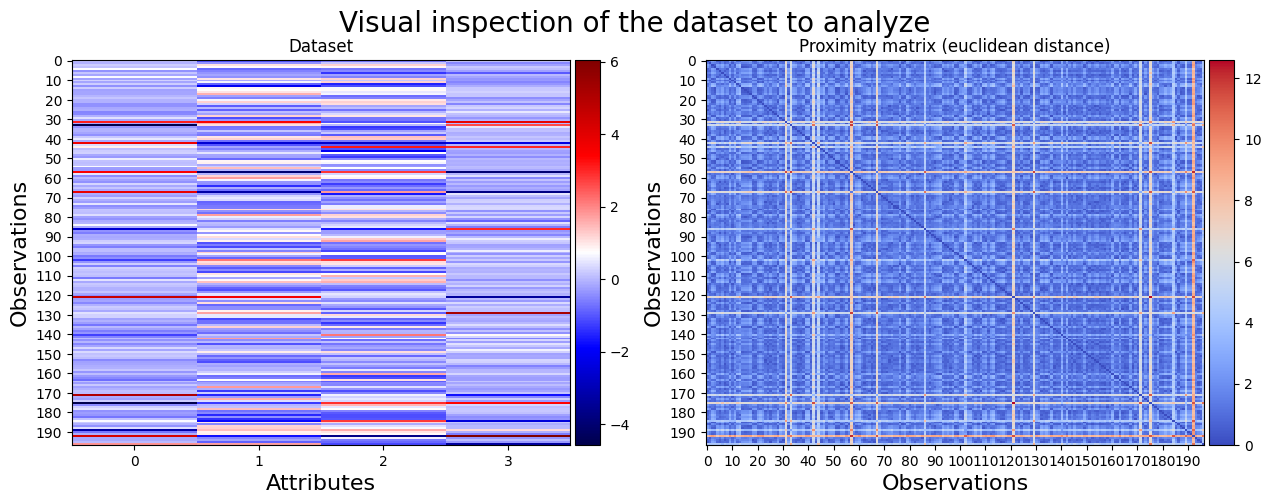

In [5]:
# Proximity matrix after scaling
# ------------------------------
distance_metric = 'euclidean'
PM_transformed = pdist(X_transformed, metric=distance_metric)
PM_transformed = sf(PM_transformed).round(2)



# Visualization after scaling
# ---------------------------
# Choose your preferred style: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('default')
from mpl_toolkits.axes_grid1 import make_axes_locatable   #to adjust the colorbar

fig1 = plt.figure(figsize=(15,5))
fig1.suptitle('Visual inspection of the dataset to analyze', fontsize=20)

# Plot 1: 2D image of the entire dataset
ax1 = fig1.add_subplot(121)
im1 = ax1.imshow(X_transformed, interpolation='nearest', aspect='auto', cmap='seismic')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)

ax1.set_xlabel('Attributes', fontsize=16)
ax1.set_xticks(np.arange(0, M, step=1))
ax1.set_ylabel('Observations', fontsize=16)
ax1.set_yticks(np.arange(0, N, step=10))
ax1.title.set_text('Dataset')


# Plot 2: proximity matrix
ax2 = fig1.add_subplot(122)
im2 = ax2.imshow(PM_transformed, interpolation='nearest', aspect='auto', cmap='coolwarm')

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

ax2.set_xlabel('Observations', fontsize=16)
ax2.set_xticks(np.arange(0, N, step=10))
ax2.set_ylabel('Observations', fontsize=16)
ax2.set_yticks(np.arange(0, N, step=10))
ax2.title.set_text('Proximity matrix (%s distance)' % distance_metric)

plt.show()

# **Step 2**: Investigation on outliers - Proximity-based approaches


Useful references:
- [NN](https://scikit-learn.org/stable/modules/neighbors.html) see section 1.6.1.1. "Finding the Nearest Neighbors" and also check previous lab solutions (e.g., Lab07, Lab08).

- [LOF](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor) [and also slide no.8 and [WIki](https://en.wikipedia.org/wiki/Local_outlier_factor)]. Here, you don't have to manually implement the algorithm, but only to correctly use the sklearn package to obtain LOF.

**2.1 Nearest neighbor (NN)**
- Choose the value of the design parameters.
- Apply the algorithm.
- Discover, count, and label the outliers.
- Remove the outliers from the dataset, obtaining a _clean_ dataset (X_clean_NN).

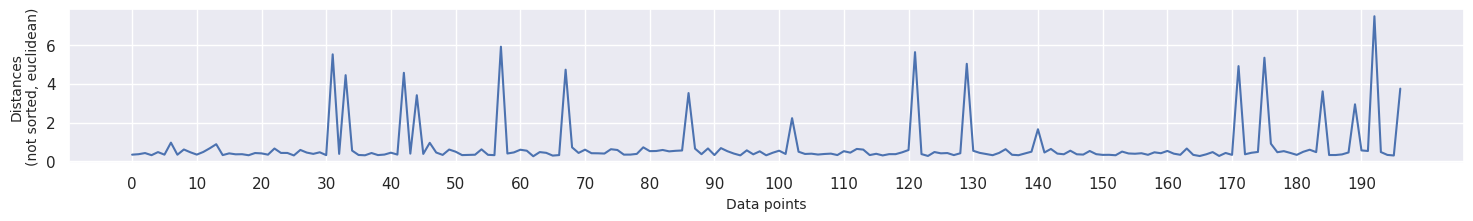

In [20]:
# Apply the algorithm
from sklearn.neighbors import NearestNeighbors as knn
neighborhood_order = 5

# Find neighborhood
neighborhood_set   = knn( n_neighbors=neighborhood_order, algorithm='ball_tree').fit(X_transformed)
distances, indices = neighborhood_set.kneighbors(X_transformed)

# compute distances from kth nearest neighbors and sort them
dk_sorted     = np.sort(distances[:,-1])
dk_sorted_ind = np.argsort(distances[:,-1])


# Identify the outliers as those points with too high distance from their own kth nearest neighbor. Hint: choose one of the possible solutions of Lab09:
# 1: use the knee point                                 --> knee_x, knee_y
# 2: decide a percentage of outliers a-priori (n%)      --> n [%]
# 3: use a threshold from the above plot, left panel    --> dk_th = k

# Here, I use method no.3

# plot distances
# fig2 = plt.figure(figsize=(18,2))
figKNN = plt.figure('kNN distance values', figsize=(18,2))
plt.plot(distances[:,-1])
plt.xlabel('Data points', fontsize=10)
plt.xticks(np.arange(0, N, step=10))
plt.ylabel('Distances\n(not sorted, %s)' % distance_metric, fontsize=10)
plt.grid()
plt.show()

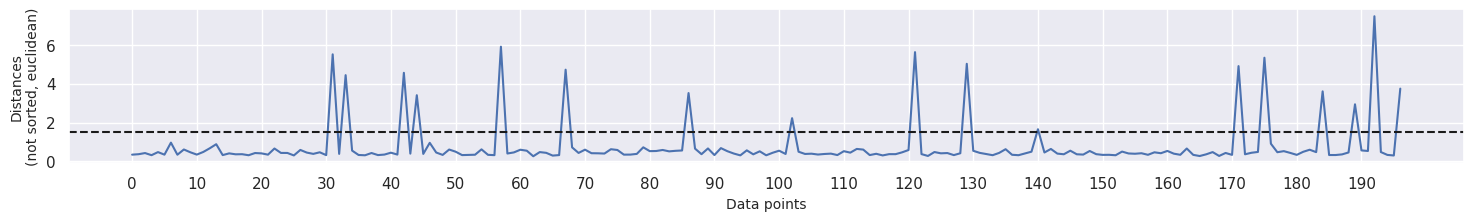

In [21]:
# set a threshold
dk_th = 1.5

# add horizontal line to check which data points exceed the selected threshold
plt.figure(figKNN)
plt.axhline(dk_th, color='k', linestyle='--')
plt.show()

**Comment:** during the lab, some of you used the method no.3, too, setting the threshold at the value of mean + 3*standard deviation. This can be also a good way to set the threshold, since we expect that values in the range (mean-3*standard deviation, mean+3*standard deviation) are normal (i.e., not anomalous), while if a sample exceeds that threshold, it can be considered outside the inherent distribution of the data.



In [23]:
# Identify and remove the outliers (i.e., data points that exceed the threshold)
id_points2remove = dk_sorted_ind[np.where(dk_sorted>=dk_th)]
OUTLIER_INDECES  = np.sort(id_points2remove)

# Label=-1 to outliers
KNN_labels = np.ones(N)
KNN_labels[OUTLIER_INDECES] = -1

# Count the no. of outliers
countKNN = len(OUTLIER_INDECES)
print(countKNN)

17


PCA: explained variation per principal component: [0.38 0.31 0.19 0.12]


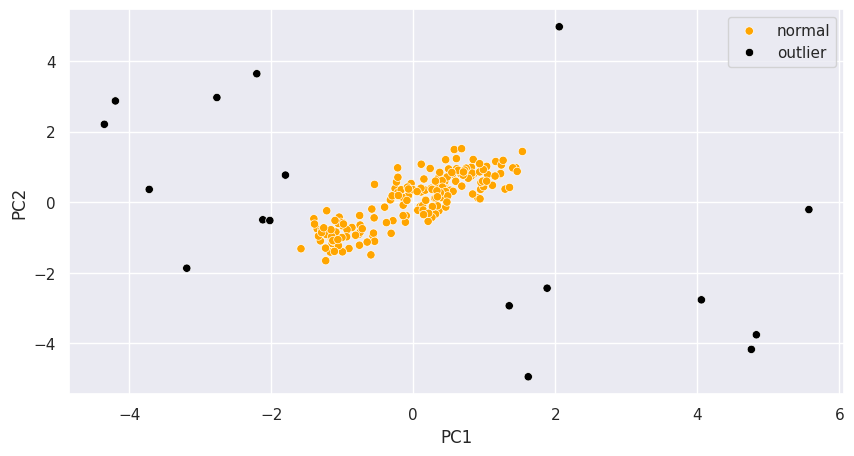

In [24]:
# Visualize the solution in a 2D scatterplot or PCA/tSNE plot (use BLACK for OUTLIERS, yellow for inliers)

from sklearn.decomposition import PCA
pca = PCA(n_components=M)
pca_result = pca.fit_transform(X_transformed)
print('PCA: explained variation per principal component: {}'.format(pca.explained_variance_ratio_.round(2)))

fig3 = plt.figure('Check the dataset', figsize=(10,5))
sns.scatterplot( x = pca_result[:,0], y = pca_result[:,1], hue=KNN_labels, palette=['black','orange'])
sns.set_theme(style='dark')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['normal','outlier'])
plt.grid()
plt.show()

**2.2 Local Outlier Factor (LOF)**

- Choose the value of the design parameters.
- Apply the algorithm.
- Discover, count, and label the outliers.
- Remove the outliers from the dataset, obtaining a _clean_ dataset (X_clean_LOF).

In [26]:
# Apply the algorithm
from sklearn.neighbors import LocalOutlierFactor
n = 0.1

lof_model  = LocalOutlierFactor(n_neighbors  = 10,
                                algorithm='ball_tree',
                                metric='minkowski', p=2,
                                metric_params = None,
                                contamination = n)
LOF_labels = lof_model.fit_predict(X_transformed)     # predict the labels (1 inlier, -1 outlier) of X according to LOF
LOF_values = lof_model.negative_outlier_factor_
# print(np.round(LOF_values,2))

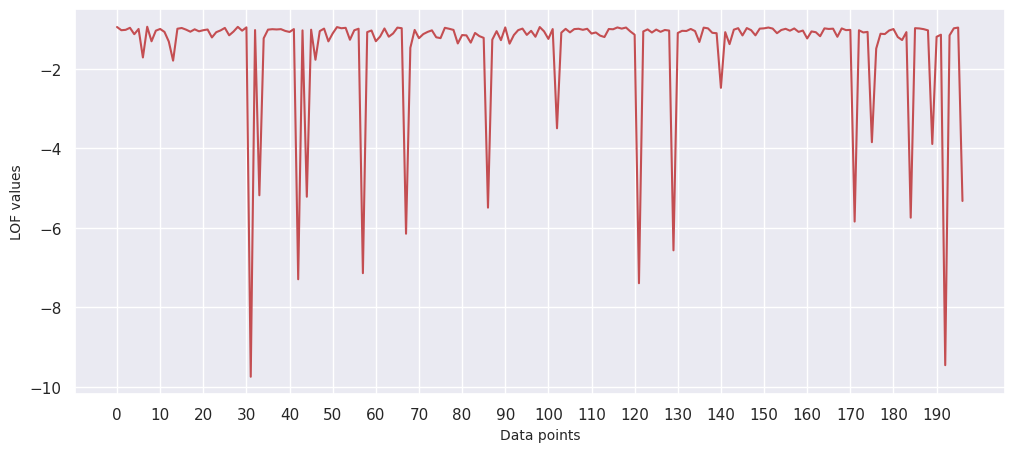

In [27]:
# Verify the outlier detection, count and label the outliers
figLOF = plt.figure('LOF values', figsize=(12,5))
plt.xlabel('Data points', fontsize=10)
plt.xticks(np.arange(0, N, step=10))
plt.ylabel('LOF values', fontsize=10)
plt.plot(LOF_values, 'r-')
plt.grid()
plt.show()

**Comment:** if you set the same value of neighborhood_order in the LocalOutlierFactor as you used for the NN you might fail to find several outliers. Remember that, even though the kNN-based and the LOF approach share a similar procedure, their strategy to define an outlier is different. For the former, an outlier is - simply - defined as such if it is far enough from the other data points (measured in terms of k-th neighbor distance). In the latter, however, a data point is considered as an outlier if its density is much _dissimilar_ from that of its neighbors. Therefore, if you set the order of neighborhood (k) too small for the LOF approach you indirectly check the density of a very small number of neighbors.

In [28]:
# Count the no. of outliers
countLOF = len(LOF_labels[LOF_labels==-1])
print(countLOF)

20


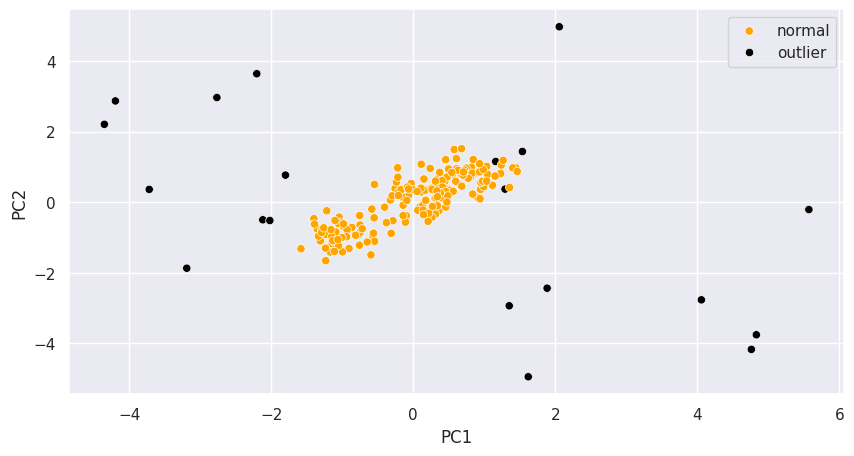

In [29]:
# Visualize the solution in a 2D scatterplot or PCA/tSNE plot (use BLACK for OUTLIERS, yellow for inliers)

fig4 = plt.figure('Check the dataset', figsize=(10,5))
sns.scatterplot( x = pca_result[:,0], y = pca_result[:,1], hue=LOF_labels, palette=['black','orange'])
sns.set_theme(style='dark')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['normal','outlier'])
plt.grid()
plt.show()

# **Step 3**: Investigation on outliers - Principal Component Analysis (PCA)

**Steps:**

- Decide on the number of principal components (q)
- Run PCA. You can use [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).
- Reconstruct the dataset with (only) q components
- Compute the reconstruction error (RE) for every data points (from the q-dimensional space to the N-dimensional space)
- Idenfity, count, and label the outliers.
- Remove the outliers from the dataset, obtaining a _clean_ dataset (X_clean_PCA).

_Note: sklearn.decomposition.PCA implements linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD._

```q ``` is the same as ```NCOMP```.

You can identify the outliers as those points too deviating from the main PCs.

You learnt **two possible methods** to implement this idea (see Prof. Stella's slides nn.13-15):

1.   use a **threshold on the reconstruction errors** --> "Objects with large reconstruction errors are anomalies"
2.   use the **Chi-square distribution**  --> "An observation is anomalous if, for a given significance level alpha, the sum of the squared values of its projection on the first q PCs is larger than X^2_q(alpha).

In [47]:
# **Method no.1**
# ---------------

# Decompose the dataset into NCOMP components using PCA
# from sklearn.decomposition import PCA    # already imported
NCOMP      = 2                                   # number of components
pca        = PCA(n_components = NCOMP)
pca_result = pca.fit_transform(X_transformed)    # use X_transformed that is the dataset after standardization (important to ensure robustness to the PCA output)
print('PCA: explained variation per principal component: {}'.format(pca.explained_variance_ratio_.round(2)))


# Reconstruction
X_reconstructed = pca.inverse_transform(pca_result)
# print( X_reconstructed.shape )

# Error in the reconstruction for every data point
RE_points = np.sum((X_transformed - X_reconstructed) ** 2, axis=1)


# MSE
RE_mean = RE_points.mean()
RE_std  = RE_points.std()
print([RE_mean.round(2), RE_std.round(2)])

# Threshold
RE_th = RE_mean

PCA: explained variation per principal component: [0.38 0.31]
[1.23, 4.59]


In [48]:
# Identification of outliers using PCA-Method no.1
OUTLIER_INDECES = np.array(np.where(RE_points > RE_th)).T

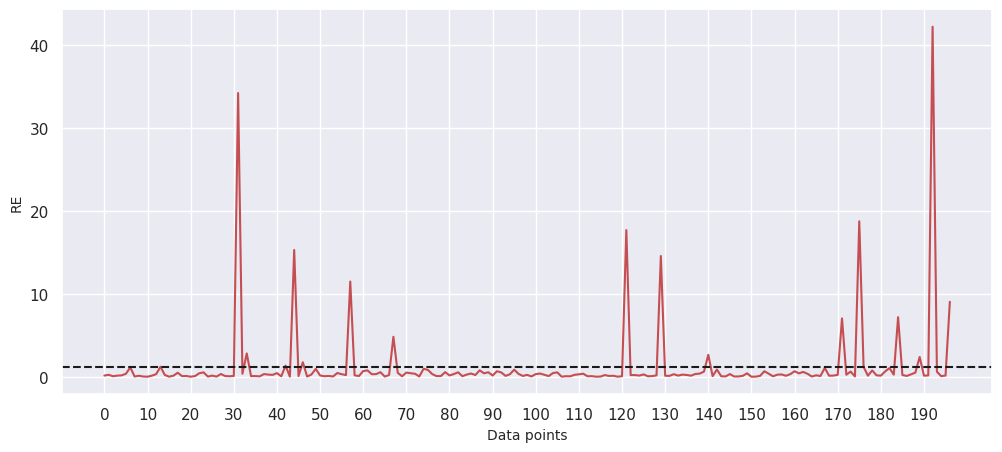

In [49]:
# Verify the outlier detection via visual inspection (Method no.1)
figX = plt.figure('PCA RE values', figsize=(12,5))
plt.xlabel('Data points', fontsize=10)
plt.xticks(np.arange(0, N, step=10))
plt.ylabel('RE', fontsize=10)
plt.plot(RE_points, 'r-')
plt.axhline(RE_th, color='k', linestyle='--')
plt.grid()
plt.show()

If you are using Method no.1, then skip _from here to_ the block named "Labelling".

In [53]:
# **Method no.2** [REF: https://apps.dtic.mil/sti/pdfs/ADA465712.pdf]
# ---------------

NCOMP      = 2    # number of components
pca        = PCA(n_components = NCOMP)
pca_result = pca.fit_transform(X_transformed)
print('PCA: explained variation per principal component: {}'.format(pca.explained_variance_ratio_.round(2)))


df = NCOMP             # no. degrees of freedom of the Chi-square distribution
alpha = 0.05           # (desired) significant level
X2_th = 5.991          # "critical value" given alpha=0.05 and df=2. See, e.g., https://www.scribbr.com/wp-content/uploads/2022/05/Chi-square-table.pdf
print(X2_th)

# alternatively, you can compute the percent point function (ppf) of 95% for the chi-squared distribution, which is essentially
# the inverse of the cumulative distribution function. This value is often called the critical value.
z95 = chi2.ppf(1-alpha, df=NCOMP)
print(z95.round(4))

print('We can realize they are the same value (if you set NCOMP to 2, otherwise you need to check the linked table and find out the new z95 value).')

PCA: explained variation per principal component: [0.38 0.31]
5.991
5.9915
We can realize they are the same value (if you set NCOMP to 2, otherwise you need to check the linked table and find out the new z95 value).


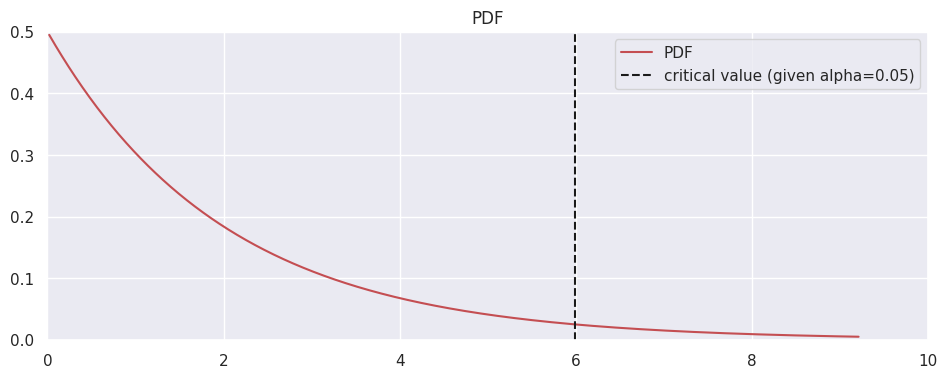

In [54]:
# Show Chi-square distribution PDF with the desired alpha level
x = np.linspace(chi2.ppf(0.01, df), chi2.ppf(0.99, df), 1000)

figXI = plt.figure(figsize=(25,4))
figXI.add_subplot(122)
plt.plot(x, chi2.pdf(x, df), 'r-', label='chi2 PDF')
plt.axvline(z95, color='k', linestyle='--')
plt.legend(['PDF','critical value (given alpha=0.05)'])
plt.xlim(0, 10)
plt.ylim(0, 0.5)
plt.title('PDF')
plt.grid()
plt.show()

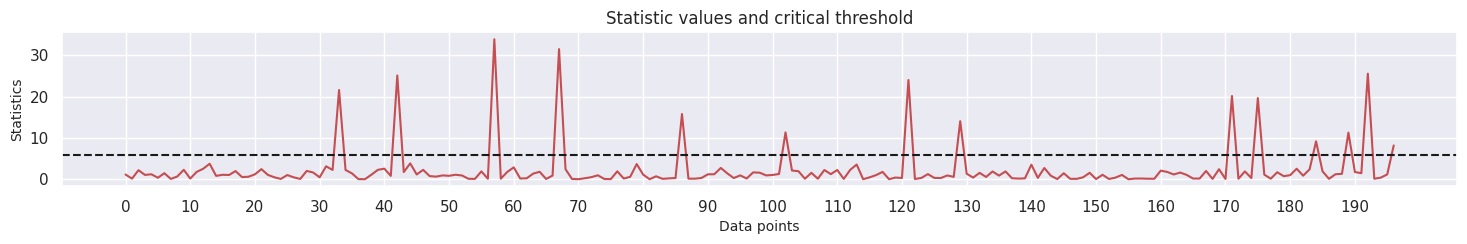

In [55]:
# Compute the statistic from the given sample (of population):
# We know that [1]:
# 1) pca_result samples are gaussian distributed
# 2) pca_result**2/lambda are normally distributed
# 3) the sum of all pca_result**2/lambda is Chi-square distributed
# [1] Shyu, M. L., Chen, S. C., Sarinnapakorn, K., & Chang, L. (2003). A novel anomaly detection scheme based on principal component classifier.
#                                                                      Miami Univ Coral Gables Fl Dept of Electrical and Computer Engineering.

stat = np.sum( pca_result ** 2 / np.sqrt(pca.explained_variance_) , axis=1)


# Verify the outlier detection via visual inspection (Method no.2)
figPCA2 = plt.figure('PCA-based statistics', figsize=(18,2))
plt.xlabel('Data points', fontsize=10)
plt.xticks(np.arange(0, N, step=10))
plt.ylabel('Statistics', fontsize=10)
plt.plot(stat, 'r-')
plt.axhline(z95, color='k', linestyle='--')
plt.title('Statistic values and critical threshold')
plt.grid()
plt.show()

In [56]:
# Identification
OUTLIER_INDECES = np.array( np.where(stat > z95) ).T

The following 2 blocks are to be run in both cases you chose Method no.1 or Method no.2.

In [57]:
# Labelling
PCA_labels = np.ones(N)
PCA_labels[OUTLIER_INDECES] = -1

In [58]:
# Count the no. of outliers
countPCA = len(OUTLIER_INDECES)
print(countPCA)

14


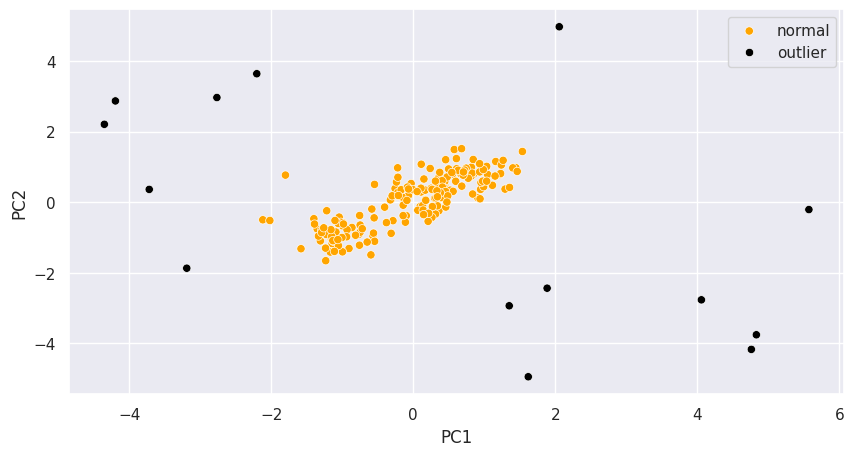

In [59]:
# Visualize outliers in the dataset with representation onto the first two PCA principal components
fig5 = plt.figure('Check the dataset', figsize=(10,5))
sns.scatterplot( x = pca_result[:,0], y = pca_result[:,1], hue=PCA_labels, palette=['black','orange'])
sns.set_theme(style='dark')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['normal','outlier'])
plt.grid()
plt.show()

# **Step 4**: Compare the above solutions (unsupervised)
Hint: verify agreement or mismatches among the different algorithms (e.g., visual inspection, Rand index on labels, ...).

Rand between KNN and LOF: 0.8937533615495467
Rand between LOF and PAC(selected method): 0.78
Rand between KNN and PAC(selected method): 0.88


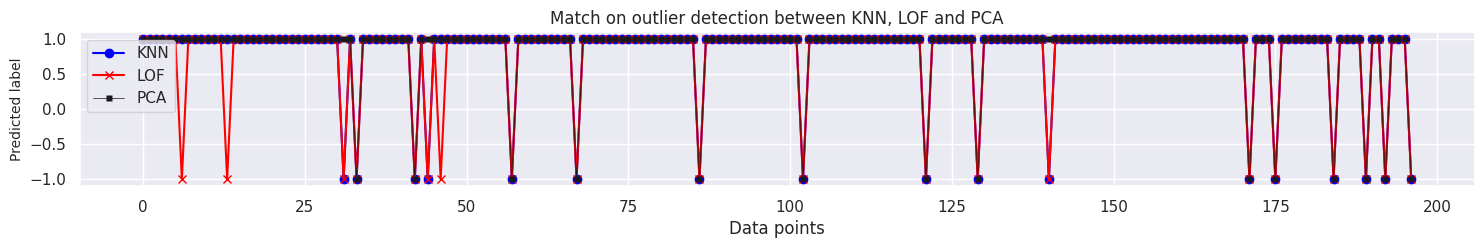

In [60]:
# Rand index
from sklearn.metrics.cluster import rand_score, adjusted_rand_score

R_KNN_LOF = adjusted_rand_score(KNN_labels, LOF_labels)
R_LOF_PCA = adjusted_rand_score(LOF_labels, PCA_labels)
R_KNN_PCA = adjusted_rand_score(KNN_labels, PCA_labels)
print('Rand between KNN and LOF:', R_KNN_LOF)
print('Rand between LOF and PAC(selected method):', np.round(R_LOF_PCA,2))
print('Rand between KNN and PAC(selected method):', np.round(R_KNN_PCA,2))


# Visually inspect the match between the outliers found by the NN and LOF
fig20 = plt.figure('Comparison spotted outliers', figsize=(18,2))
plt.plot(KNN_labels, color='blue', marker="o", label='NN')
plt.plot(LOF_labels, color='red', marker="x", label='LOF')
plt.plot(PCA_labels, color='k', marker="s", label='PCA', markersize=5, markeredgecolor='none', linewidth=0.5)
plt.xlabel('Data points')
plt.ylabel('Predicted label', fontsize=10)
plt.title('Match on outlier detection between KNN, LOF and PCA')
plt.legend(["KNN", "LOF", "PCA"])
plt.grid()
plt.show()

# **Step 5**: Validate your solutions using the TRUE labels (supervised)
Hint: use visual inspection, Rand index on labels, confusion matrix.

In [68]:
# Load TRUE labels
TRUElabels = np.load('TRUElabels_lab09.npy')

# Replace all labels that are not outliers with 1 (keep -1 only for outliers)
TRUElabels[np.where(TRUElabels>=0)] = 1

In [70]:
# Supervised validation
R_KNN_TRUE = adjusted_rand_score(KNN_labels, TRUElabels)
R_LOF_TRUE = adjusted_rand_score(LOF_labels, PCA_labels)
R_PCA_TRUE = adjusted_rand_score(PCA_labels, TRUElabels)
print('Rand between KNN and TRUE labels:', np.round(R_KNN_TRUE,2))
print('Rand between LOF and TRUE labels:', np.round(R_LOF_TRUE,2))
print('Rand between PAC(selected method) and TRUE labels:', np.round(R_PCA_TRUE,2))

Rand between KNN and TRUE labels: 1.0
Rand between LOF and TRUE labels: 0.78
Rand between PAC(selected method) and TRUE labels: 0.88


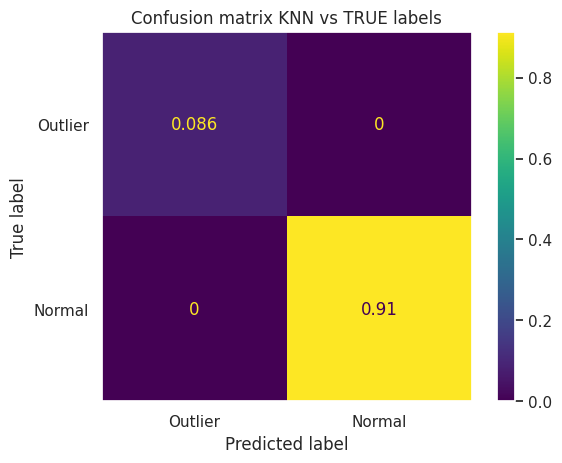

In [73]:
# confusion matrix (2 classes: "normal"/"outliers").
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(KNN_labels, TRUElabels, normalize='all')
metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Outlier", "Normal"]).plot()
plt.title('Confusion matrix KNN vs TRUE labels')
plt.show()

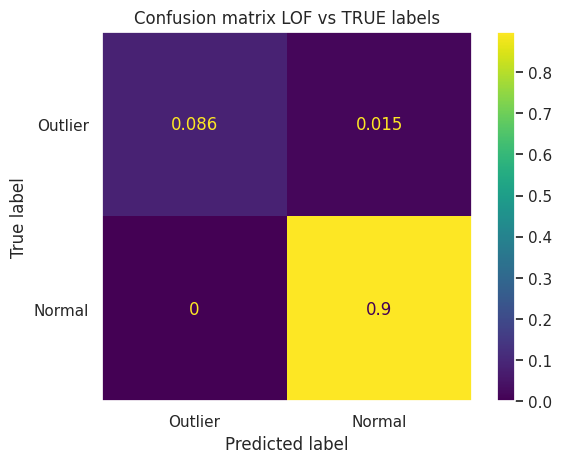

In [74]:
confusion_matrix2 = metrics.confusion_matrix(LOF_labels, TRUElabels, normalize='all')
metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels = ["Outlier", "Normal"]).plot()
plt.title('Confusion matrix LOF vs TRUE labels')
plt.show()

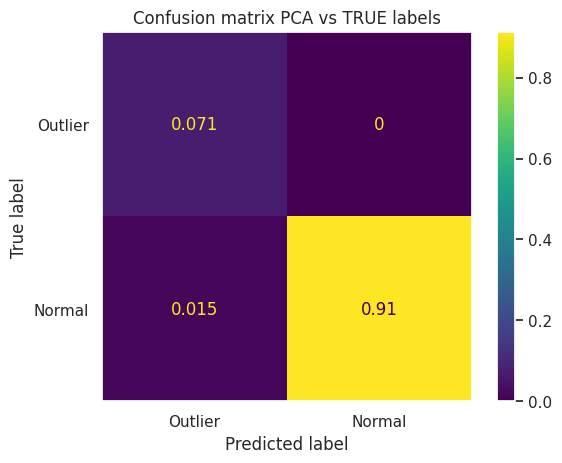

In [75]:
confusion_matrix3 = metrics.confusion_matrix(PCA_labels, TRUElabels, normalize='all')
metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix3, display_labels = ["Outlier", "Normal"]).plot()
plt.title('Confusion matrix PCA vs TRUE labels')
plt.show()

# _This it the end of Lab session #09_ ✅


## Utility functions

Retrieve utility functions from previous labs, if needed.